# Imports

In [722]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
import json
import math
import seaborn as sns
import pylab

# stats imports
from scipy.stats import norm
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# matching imports
import networkx as nx

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
#from src.data import words_clusters

# Data Loading

Ratings on movies obtained from: https://grouplens.org/datasets/movielens/
--> The 25M dataset at the very bottom of the page is used. Download:\
\
movies.csv as ratings_movies.csv\
ratings.csv as ratings_ratings.csv\
links.csv as ratings_links.csv\

In [723]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

# Data Merging and Cleaning - Movies Dataset

In [724]:
# df_movies has duplicates of the same movies which will be discarded based on keeping  
# the entry that has the least number of missing values among the other columns. Only 
# duplicate mmovies with equal countries are kept
df_movies['missing_values'] = df_movies.isnull().sum(axis=1)

# for each title, find the row with the least missing values
df_movies = df_movies.loc[df_movies.groupby(['title', 'countries'])['missing_values'].idxmin()]

# dropping 'missing_values' column
df_movies = df_movies.drop(columns=['missing_values'])

In [725]:
# doing the same duplicates cleaning as before for df_tmdb, considering 
# 'production_countries' instead of 'countries'
df_tmdb['missing_values'] = df_tmdb.isnull().sum(axis=1)

# for each title, find the row with the least missing values
df_tmdb = df_tmdb.loc[df_tmdb.groupby(['title', 'production_countries'])['missing_values'].idxmin()]

# dropping 'missing_values' column
df_tmdb = df_tmdb.drop(columns=['missing_values'])

In [726]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [727]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [728]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

In [729]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [730]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [731]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [732]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

In [733]:
# retrieving mean ratings
mean_ratings = df_ratings_ratings.groupby(df_ratings_ratings["movieId"]).mean()
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_tmdb_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 24270 unique movies in our movies dataset that have ratings given by the found dataset.


In [734]:
# binning ratings to match viewers regular rating style (.5 vote scale)
df_movies_tmdb_ratings['mean_rating_binned'] = df_movies_tmdb_ratings.mean_rating.mul(2).round().div(2)

In [735]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [736]:
# dropping release date outliers
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(df_movies_tmdb_ratings[df_movies_tmdb_ratings['release_date'] == 1010].index)

In [737]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

Dealing with multiple genres movies is not trivial. Exploding multiple-genres movies might be a solution but one needs to be careful about the influence of this on the overall statistics of the dataframe. A quick analysis on the #genres distribution shows the latter to be left-skewed, this implies that generally a movie has a low number of genres when this is larger than 1. This could justisfy the choice of exploding multiple genres movies. For later on analysis, a possible solution would be to choose unique movies starting from the standard movies dataframe, selecting a multiple repeated times movie based on the most relevant genre among the ones that belong to it.

The mean number of genres of a given movie is:  5


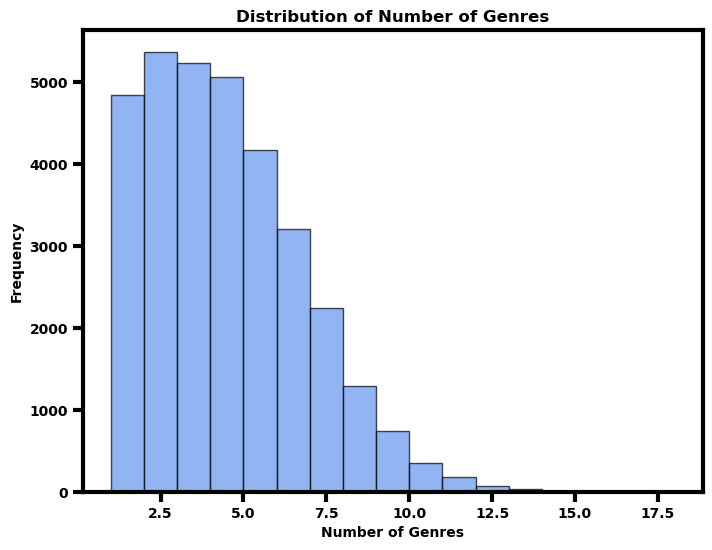

In [738]:
# getting the mean
print(f'The mean number of genres of a given movie is: ', math.ceil(df_movies_tmdb_ratings['genres'].apply(len).mean()))

# plotting the distribution
n_genres = df_movies_tmdb_ratings['genres'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_genres, bins=range(1, max(n_genres) + 2), edgecolor='black', alpha=0.7, color='cornflowerblue')

plt.title('Distribution of Number of Genres', weight='bold')
plt.xlabel('Number of Genres', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)
plt.grid(False)

In addition, when exploding only some relevant genre-wise movies copies will be kept. For example, if a movie has between genres 'Drama' and 'Acid western', with the first one being way more common than the second in the dataframe, only the movie copy with 'genre' == 'drama' is kept. This allows for a smaller influence of the explode operation on the overall statistics of the datframe, while maintaining a nice standard dataframe structure which is easy to handle genre-wise. 

In [739]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [740]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

# converting 'genres' column type
df_movies_tmdb_ratings['genres'] = df_movies_tmdb_ratings['genres'].astype(str)

Now that the genres column has been cleaned, a similar analysis needs to be performed for the 'spoken_languages' one and for 'countries'. Regarding the first one, since the TMDB dataset 'original_language' column has no missing values and has a standard format of one language per movie (e.g. en), this can be used without losing too much information or adding another heavy cleaning code. Considering the 'countries' column, one can follow a similar reasoning as before:

The mean number of countries of a given movie is:  2


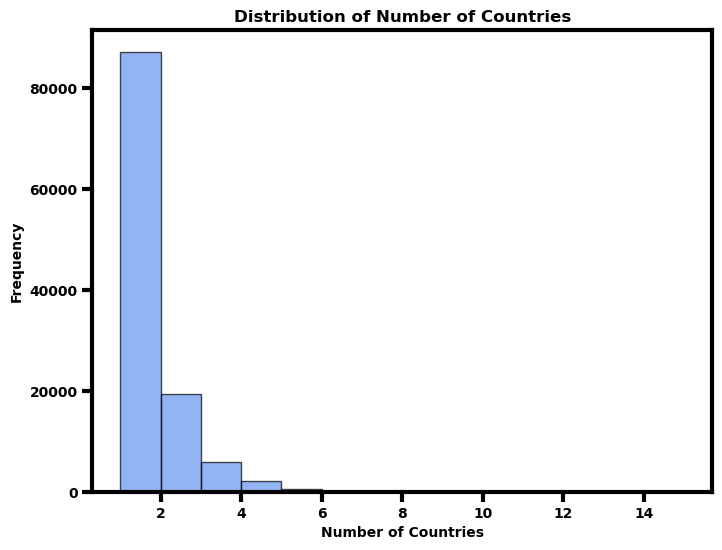

In [741]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

# getting the mean
print(f'The mean number of countries of a given movie is: ', math.ceil(df_movies_tmdb_ratings['countries'].apply(len).mean()))

# plotting the distribution
n_countries = df_movies_tmdb_ratings['countries'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_countries, bins=range(1, max(n_countries) + 2), edgecolor='black', alpha=0.7, color='cornflowerblue')

plt.title('Distribution of Number of Countries', weight='bold')
plt.xlabel('Number of Countries', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)
plt.grid(False)

The distribution is heavily right-skewed. Therefore, exploding by countries will not alter the statistics of the dataframe in a too relevant way. Since the number of added entries through exploding is not too large and since one of the main interests of the team's datastory is the geographical analysis of movies, all countries will be kept (i.e. no relevant countries procedure will be applied, opposite to what has been done for genres). Note that, once again, depending on the interested analysis to be performed only one entry for a specific duplicated movie can be easily considered with the current dataframe structure.

In [742]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [743]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].fillna(0)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [744]:
unique_titles_now = len(df_movies_tmdb_ratings["title"].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 23518 unique movies in the standard movies dataset.
There were 79347 unique movies in the initial movies dataset.


# Cleaning - Characters Dataset

In [745]:
# clean characters 'release_date' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

As for now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize.

# General statistics

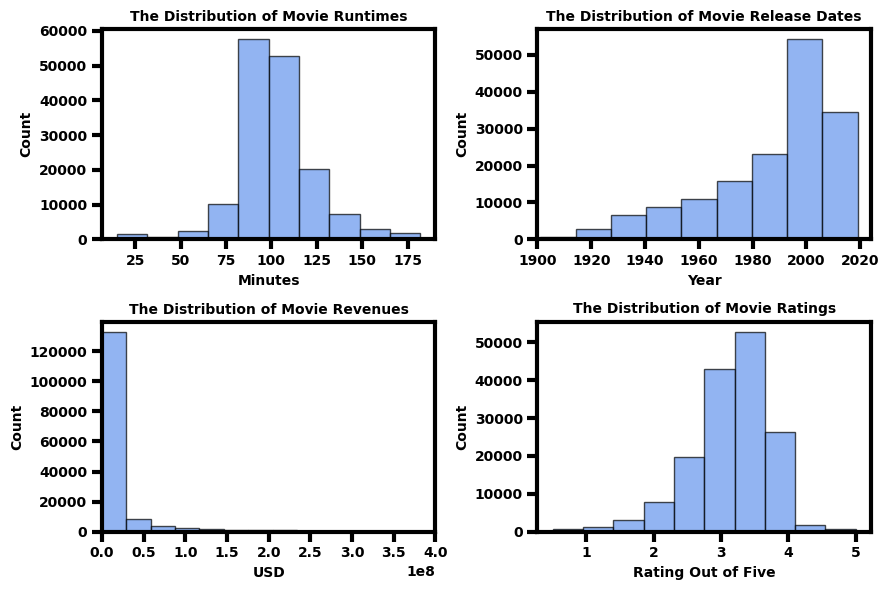

In [746]:
# the standard for our plots; bolded labels, sans-serif font, clean color
fig, ax = plt.subplots(2,2,figsize= (9,6), sharey = False, sharex = False)

hfont = {'fontname':'sans-serif'}
rcParams['font.weight'] = 'bold'
rcParams['axes.linewidth'] = 3

quantities = ['runtime', 'release_date', 'revenue', 'mean_rating']
quantities_x = ['Minutes', 'Year', 'USD', 'Rating Out of Five']

sbplt = ax[0,0]
sbplt.hist(df_movies_tmdb_ratings[quantities[0]].values, edgecolor='black', alpha=0.7, bins = 10, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Runtimes", **hfont, weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[0], weight='bold', fontsize=10)
sbplt.set_ylabel("Count", weight='bold', fontsize=10)
sbplt.tick_params(axis='both', which='major', width=3, size=7)
    
sbplt = ax[0,1]
sbplt.hist(df_movies_tmdb_ratings[quantities[1]].values, edgecolor='black', alpha=0.7, bins = 10, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Release Dates", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[1], weight='bold', fontsize=10)
sbplt.set_ylabel("Count", weight='bold', fontsize=10)
sbplt.set_xlim([1900, 2024])
sbplt.tick_params(axis='both', which='major', width=3, size=7)

sbplt = ax[1,0]
sbplt.hist(df_movies_tmdb_ratings[quantities[2]].values, edgecolor='black', alpha=0.7, bins = 100, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Revenues", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[2], weight='bold', fontsize=10)
sbplt.set_ylabel("Count", weight='bold', fontsize=10)
sbplt.set_xlim([0, 0.4e9])
sbplt.tick_params(axis='both', which='major', width=3, size=7)

sbplt = ax[1,1]
sbplt.hist(df_movies_tmdb_ratings[quantities[3]].values, edgecolor='black', alpha=0.7, bins = 10, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Ratings", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[3], weight='bold', fontsize=10)
sbplt.set_ylabel("Count", weight='bold', fontsize=10)
sbplt.tick_params(axis='both', which='major', width=3, size=7)

fig.tight_layout()

In [747]:
diagnostic.kstest_normal(df_movies_tmdb_ratings['runtime'].values, dist = 'norm') 

(0.08839985488673258, 0.0009999999999998899)

Although the runtime normality test returns a low p-value, leading us to reject the null hypothesis that the data is normally distributed, the histogram above shows a roughly bell-shaped plot for movie runtime. We know that Kolmogorov-Smirnov tests are sensitive to sample size, and our dataset contains >150K entries. Therefore, a Q-Q plot is employed to further assess normality.

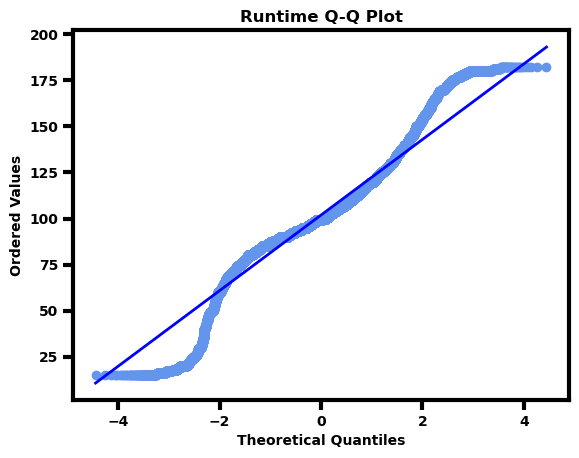

In [748]:
fig, ax = plt.subplots()
res = stats.probplot(df_movies_tmdb_ratings['runtime'].values, dist="norm", plot=ax)

line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

plt.title("Runtime Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", weight='bold', fontsize=10)
plt.ylabel("Ordered Values", weight='bold', fontsize=10)
plt.tick_params(axis='both', which='major', width=3, size=7)

plt.show()

The steep increases near the plot's edges indicate at runtime values at the extremes of our distribution, there are less values than expected if the plot were to follow a normal trend. The opposite is true for the flatter region of the plot near the center of the theoretical quantiles, indicating we have more runtimes close to the mean of the distribution than expected if there runtimes were normal. So, our runtime data is approximately normal but with a more datapoints more aggregated towards the distribution's mean.

In [749]:
diagnostic.kstest_normal(df_movies_tmdb_ratings['revenue'].values, dist = 'exp') 

(0.5689649291282968, 0.0009999999999998899)

Similarly to the runtime normality test, the revenue exponential test returns a low p-value, leading us to reject the null hypothesis that the data is exponentially distributed. However, the histogram above shows a roughly power-law plot for movie revenue. We know that Kolmogorov-Smirnov tests are sensitive to sample size, and our dataset contains >150K entries. Therefore, a complementary cumulative density function of the revenue data is prepared.

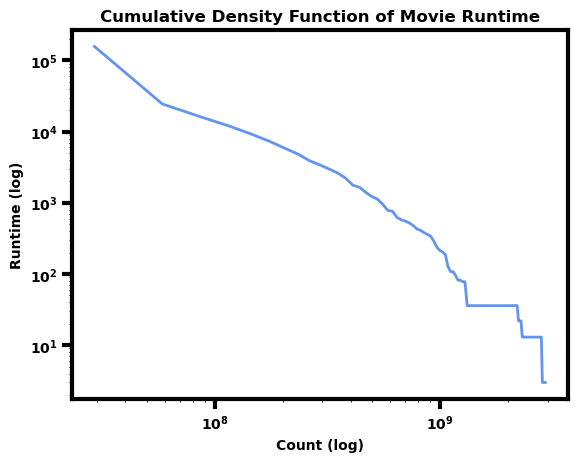

In [750]:
fig, ax = plt.subplots()

array_cumulative=plt.hist(df_movies_tmdb_ratings['revenue'].values,bins=100,log=True,cumulative=-1,histtype='step', visible=False)
plt.loglog(array_cumulative[1][1:],array_cumulative[0])

line = ax.get_lines()[0]
line.set_color('cornflowerblue') 
line.set_linewidth(2)

plt.title('Cumulative Density Function of Movie Runtime', weight='bold')
plt.xlabel('Count (log)', weight='bold')
plt.ylabel('Runtime (log)', weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)
plt.show()

The CCDF of runtime is approximately linearly decreasing, indicative the runtime data to be approximately power law distributed.

In [751]:
diagnostic.kstest_normal(df_movies_tmdb_ratings['mean_rating'].values, dist = 'norm') 

(0.08467757520990138, 0.0009999999999998899)

Although the mean rating normality test returns a low p-value, we are again convinced this isn't the case based on visual inspection of the ratings distribution. Therefore, a Q-Q plot is again employed to further assess normality.

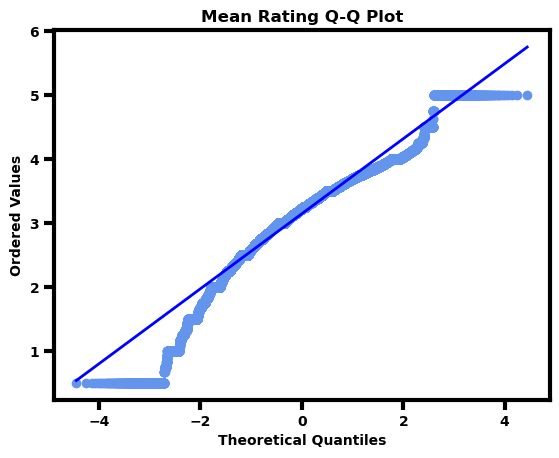

In [752]:
fig, ax = plt.subplots()
res = stats.probplot(df_movies_tmdb_ratings['mean_rating'].values, dist="norm", plot=ax)

line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

plt.title("Mean Rating Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", weight='bold', fontsize=10)
plt.ylabel("Ordered Values", weight='bold', fontsize=10)
plt.tick_params(axis='both', which='major', width=3, size=7)

plt.show()

Given the central portion of the Q-Q plot is flatter and the edges steeper, we again conclude that mean ratings is approximately normally distributed but there are more datapoints aggregated about the mean than there would be in the case of a normal distribution.

## Movie ratings statistics

In [753]:
df_movies_tmdb_ratings["mean_rating"].describe()

count    157315.000000
mean          3.146489
std           0.600136
min           0.500000
25%           2.833333
50%           3.227273
75%           3.545455
max           5.000000
Name: mean_rating, dtype: float64

The movie ratings found for part of the CMU dataset have a mean -- which we report owing to our above conclusion of the mean ratings being approximately normal -- of 3.15. The standard deviation is 0.6 and no ratings under 0.5 are observed, whereas perfect ratings are observed.

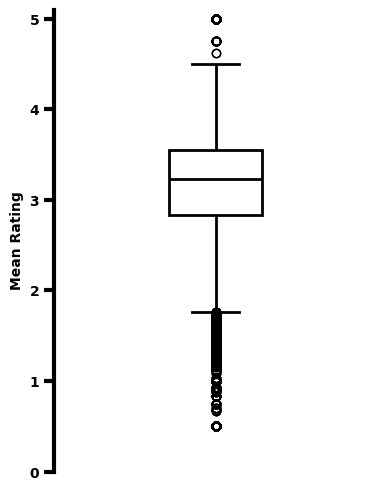

In [754]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_tmdb_ratings['mean_rating'], color='white', linewidth=2, linecolor='black', width=0.3)

sns.despine(offset=5, trim=False, bottom=True)
plt.xticks([])
plt.ylim([0,5.1])
plt.ylabel("Mean Rating", weight='bold', fontsize=10)
plt.tick_params(axis='both', which='major', width=3, size=7)

fig.tight_layout()

As expected, the movie ratings are approximately normally distributed with equivalent whisker sizes in the above boxplot and a median centered about at the centre of the IQR. Many outliers are observed, however we will not consider these as outliers given the data exists over a five point scale and no extreme values greatly drive skew in the movies ratings.

In [755]:
genres_counts = df_movies_tmdb_ratings.groupby("genres").size()
genres_counts = genres_counts.sort_values(ascending=False)
genres_top = genres_counts.head(20)

top_genres_count = genres_top.sum()
all_genres_count = genres_counts.sum()

print(f"The top 20 basic genres in the movies dataset account for {round(top_genres_count/all_genres_count * 100)}% of all movie genres.")

top_genres = genres_top.index.tolist()
df_movies_tmdb_ratings_genres_filtered = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"].isin(top_genres)].copy()

The top 20 basic genres in the movies dataset account for 68% of all movie genres.


The top 20 genres reported in the CMU dataset all have approximately normal distributions with peaks (means) between the 3.0 and 3.5 rating bins, as expected given the population's mean rating of 3.15.

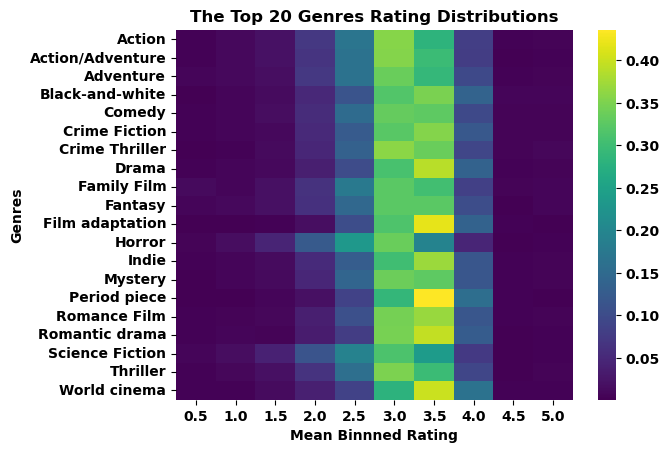

In [756]:
df_genres_meanratings = pd.crosstab(df_movies_tmdb_ratings_genres_filtered['genres'],df_movies_tmdb_ratings_genres_filtered['mean_rating_binned'], normalize='index')

ax = plt.axes()
sns.heatmap(df_genres_meanratings, annot=False, cmap='viridis', ax = ax)

ax.set_title('The Top 20 Genres Rating Distributions', weight='bold')
ax.set_xlabel('Mean Binnned Rating', weight='bold')
ax.set_ylabel('Genres', weight='bold')
plt.show()

Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

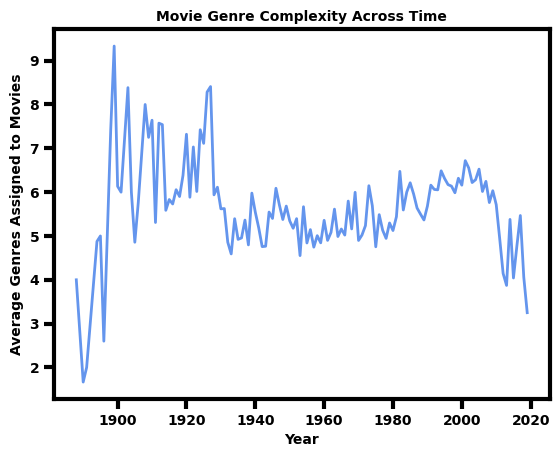

In [757]:
# count the number of genres for each film
unique_genres_count = df_movies_tmdb_ratings.groupby('title')['genres'].nunique()
unique_genres_count = unique_genres_count.to_frame()
unique_genres_count = unique_genres_count.reset_index()

unique_genres_count = unique_genres_count.rename(columns={"genres": "genres_count"}) 
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb_ratings, unique_genres_count, left_on='title', right_on='title')

mean_genres_per_year = df_movies_tmdb_ratings.groupby('release_date')["genres_count"].mean()

# visualizing if more than one genre being given to a film has increased over years
fig, ax = plt.subplots()

mean_genres_per_year.plot(kind='line')  

line = ax.get_lines()[0]
line.set_color('cornflowerblue') 
line.set_linewidth(2)

plt.title("Movie Genre Complexity Across Time", **hfont, weight='bold', fontsize=10)
plt.xlabel("Year", weight='bold', fontsize=10)
plt.ylabel("Average Genres Assigned to Movies", weight='bold', fontsize=10)
plt.tick_params(axis='both', which='major', width=3, size=7)
plt.show()


This figure produced per country and then across time period worldwide and per country would be interesting.

## Movie rating relationships

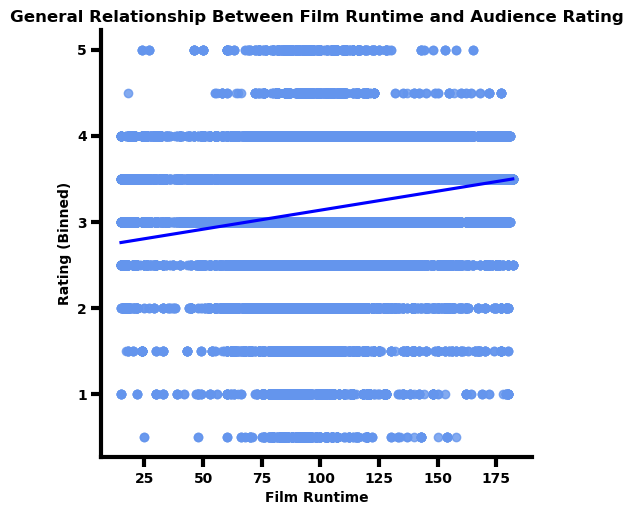

In [758]:
runtime_binned_ratings = df_movies_tmdb_ratings[['runtime','mean_rating_binned']]
sns.lmplot(x='runtime',y='mean_rating_binned', data=runtime_binned_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Film Runtime", weight='bold')
plt.ylabel("Rating (Binned)", weight='bold')
plt.title("General Relationship Between Film Runtime and Audience Rating", weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)

There may be a relationship between runtime of a movie and the audience rating.

The above performed over all regions and then across time worldwide and per region would be interesting.

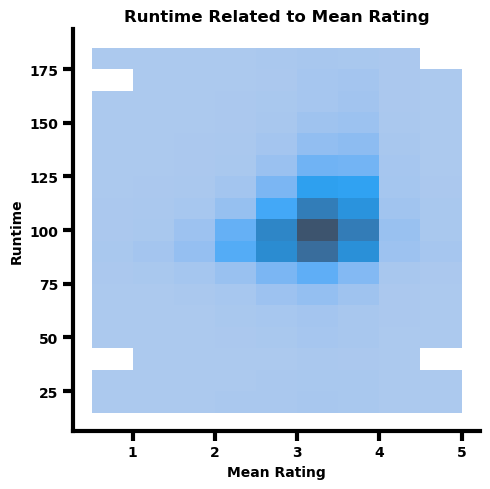

In [759]:
sns.displot(x=df_movies_tmdb_ratings['mean_rating'], y=df_movies_tmdb_ratings['runtime'], binwidth=(0.5, 10))
ax.grid(False)

plt.title("Runtime Related to Mean Rating", weight='bold')
plt.xlabel("Mean Rating", weight='bold', fontsize=10)
plt.ylabel("Runtime", weight='bold', fontsize=10)
plt.tick_params(axis='both', which='major', width=3, size=7)

plt.tight_layout()

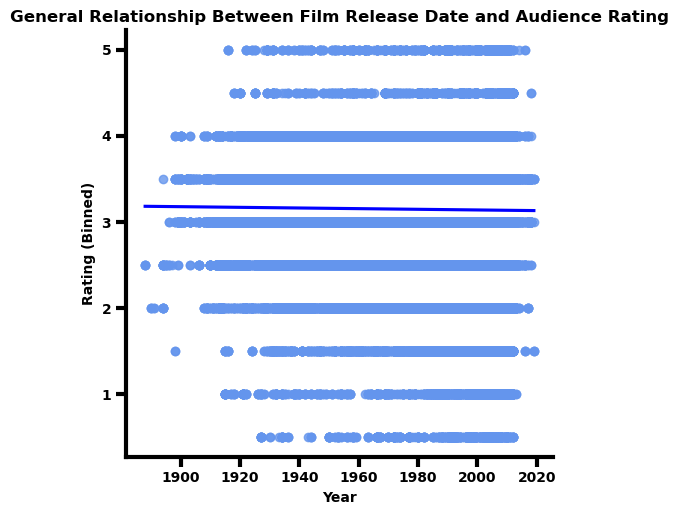

In [760]:
runtime_binned_ratings = df_movies_tmdb_ratings[['release_date','mean_rating_binned']]
sns.lmplot(x='release_date',y='mean_rating_binned', data=runtime_binned_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Year", weight='bold')
plt.ylabel("Rating (Binned)", weight='bold')
plt.title("General Relationship Between Film Release Date and Audience Rating", weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)

Again, the above per region and then per time period worlwide and per region would be interesting to observe.

Such plots prepared for dummy variables per main genre would be interesting.

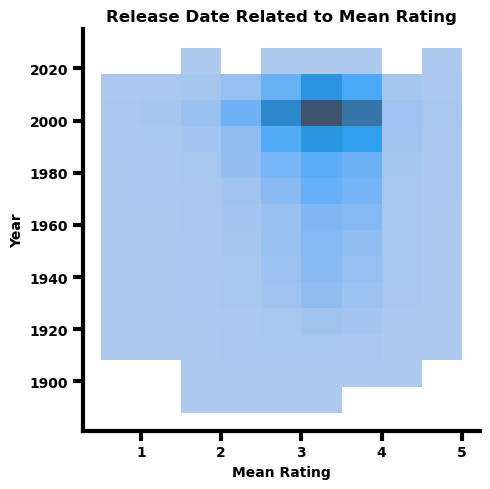

In [761]:
sns.displot(x=df_movies_tmdb_ratings['mean_rating'], y=df_movies_tmdb_ratings['release_date'], binwidth=(0.5, 10))
ax.grid(False)

plt.title("Release Date Related to Mean Rating", weight='bold')
plt.xlabel("Mean Rating", weight='bold', fontsize=10)
plt.ylabel("Year", weight='bold', fontsize=10)
plt.tick_params(axis='both', which='major', width=3, size=7)

plt.tight_layout()

In [762]:
# the below has been commented out as was intensive to run and minimally informative beyond plots already above
""" quantitative_variables = ["mean_rating", "runtime", "release_date", "mean_rating_binned"]

g = sns.PairGrid(df_movies_tmdb_ratings[quantitative_variables])

g.map_lower(sns.regplot, scatter_kws={'alpha':0.3})
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True) """

' quantitative_variables = ["mean_rating", "runtime", "release_date", "mean_rating_binned"]\n\ng = sns.PairGrid(df_movies_tmdb_ratings[quantitative_variables])\n\ng.map_lower(sns.regplot, scatter_kws={\'alpha\':0.3})\ng.map_upper(sns.kdeplot, fill=True)\ng.map_diag(sns.histplot, kde=True) '

# Regression Analysis

## Maybe don't include depending on what Alexis has done.

In [763]:
# mean rating regressed over quantitative variables to determine predictors for mean rating
df_movies_ratings_final_copy = df_movies_tmdb_ratings.copy()
df_movies_ratings_final_copy['release_date'] = (df_movies_ratings_final_copy['release_date'] - df_movies_ratings_final_copy['release_date'].mean())/df_movies_ratings_final_copy['release_date'].std()
df_movies_ratings_final_copy['revenue'] = (df_movies_ratings_final_copy['revenue'] - df_movies_ratings_final_copy['revenue'].mean())/df_movies_ratings_final_copy['revenue'].std()
df_movies_ratings_final_copy['runtime'] = (df_movies_ratings_final_copy['runtime'] - df_movies_ratings_final_copy['runtime'].mean())/df_movies_ratings_final_copy['runtime'].std()

mod = smf.ols(formula='mean_rating ~ release_date + revenue + runtime',
              data=df_movies_ratings_final_copy)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1584.
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:24:33   Log-Likelihood:            -1.4055e+05
No. Observations:              157315   AIC:                         2.811e+05
Df Residuals:                  157311   BIC:                         2.812e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.1465      0.001   2110.677   

This should be repeated for dummy variables set to genres of interest to determine their predictive capacity for movie rating.

# Movies Ratings Analysis

## Nature randomization matching for causality

Main premise here is to filter for movies with unique ratings and find cause. Example used was thriller movies between the US and the UK.

In [764]:
# identifying movies that have several entries but that differ in ratings
df_movies_ratings_unique = df_movies_tmdb_ratings.drop_duplicates(subset=["title", "mean_rating"]).copy()

# keeping only movies that have several ratings, replicating random experiment
recurrent_title = df_movies_ratings_unique["title"].value_counts() > 1
df_movies_ratings_unique = df_movies_ratings_unique[df_movies_ratings_unique["title"].isin(recurrent_title[recurrent_title].index)]

In [765]:
# thriller, US versus UK, all time
thriller_us = df_movies_ratings_unique[(df_movies_ratings_unique["genres"] == "Thriller") & (df_movies_ratings_unique["countries"] == "United States of America")]
thriller_uk = df_movies_ratings_unique[(df_movies_ratings_unique["genres"] == "Thriller") & (df_movies_ratings_unique["countries"] == "United Kingdom")]

There are very few movies that are thrillers that were produced in the US and in the UK, all else being the same. Relying on nature randomization is not going to work for matching.

## Propensity scoring

The below is an example analysis of comparing a given genre (here, thriller) rating across two regions (here, UK and US) for causality analysis of country on rating. This analysis would need to be repeated per region pairing of interest, per genre of interest, across unique time subsets of the dataset based on decades/ events of interest.

In [766]:
# comparing the ratings of thriller films in the US versus the UK
thriller_us = df_movies_tmdb_ratings[(df_movies_tmdb_ratings["genres"] == "Thriller") & (df_movies_tmdb_ratings["countries"] == "United States of America")]
thriller_uk = df_movies_tmdb_ratings[(df_movies_tmdb_ratings["genres"] == "Thriller") & (df_movies_tmdb_ratings["countries"] == "United Kingdom")]

thriller_us_uk = pd.concat([thriller_us, thriller_uk])

# make the USA as a thrillers production country as the treatment
thriller_us_uk["countries"] = thriller_us_uk["countries"].apply(lambda x: x.replace("United Kingdom", "0"))
thriller_us_uk["countries"] = thriller_us_uk["countries"].apply(lambda x: x.replace("United States of America", "1"))
thriller_us_uk = thriller_us_uk.astype({'countries':'int'})


In [ ]:
# generating propensity scores based on release date and runtime, the only two real features of interest with genre held constant
thriller_us_uk['release_date'] = (thriller_us_uk['release_date'] - thriller_us_uk['release_date'].mean())/thriller_us_uk['release_date'].std()
#thriller_us_uk['revenue'] = (thriller_us_uk['revenue'] - thriller_us_uk['revenue'].mean())/thriller_us_uk['revenue'].std()
thriller_us_uk['runtime'] = (thriller_us_uk['runtime'] - thriller_us_uk['runtime'].mean())/thriller_us_uk['runtime'].std()

mod = smf.logit(formula='countries ~  release_date + runtime' , data=thriller_us_uk)
res = mod.fit()
print(res.summary())

thriller_us_uk["Propensity_score"] = res.predict()

Optimization terminated successfully.
         Current function value: 0.497935
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              countries   No. Observations:                 4935
Model:                          Logit   Df Residuals:                     4932
Method:                           MLE   Df Model:                            2
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                0.003251
Time:                        01:24:33   Log-Likelihood:                -2457.3
converged:                       True   LL-Null:                       -2465.3
Covariance Type:            nonrobust   LLR p-value:                 0.0003309
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.3961      0.036     38.985      0.000       1.326       1.466
release_date     0.1257

Low R^2 value, which is concerning. An increase in release date by one standard deviation leads to a 0.13 log odds increase in a thriller being released in the US. An increase of one standard deviation in the runtime of a movie leads to a 0.11 log odds reduction in a movie being released in the US.

In [768]:
# matching US and UK thrillers based on propensity scores
def get_similarity(propensity_score1, propensity_score2):
    return 1-np.abs(propensity_score1-propensity_score2)

not_treated = thriller_us_uk[thriller_us_uk['countries'] == 0]
treated = thriller_us_uk[thriller_us_uk['countries'] == 1]

G = nx.Graph()

for control_id, control_row in not_treated.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

balanced_thriller_us_uk = thriller_us_uk.loc[matched]

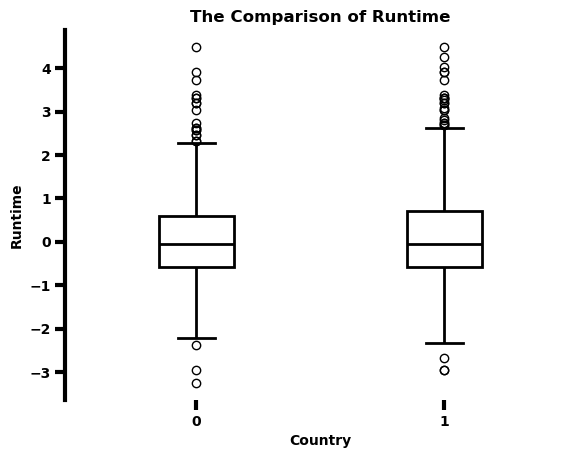

In [773]:
# assessing runtime balance in matched dataset
ax = sns.boxplot(x="countries", y="runtime", data=balanced_thriller_us_uk, color='white', linewidth=2, linecolor='black', width=0.3)
sns.despine(offset=5, trim=False, bottom=True)

plt.xlabel("Country", weight='bold')
plt.ylabel("Runtime", weight='bold')
plt.title("The Comparison of Runtime", weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)
plt.show()




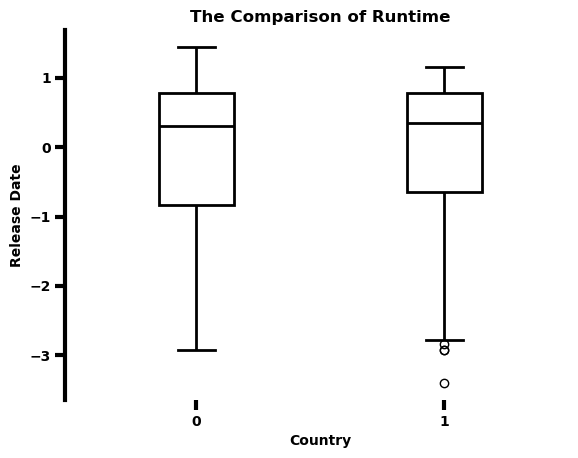

In [775]:
# assessing runtime balance in matched dataset
ax = sns.boxplot(x="countries", y="release_date", data=balanced_thriller_us_uk, color='white', linewidth=2, linecolor='black', width=0.3)
sns.despine(offset=5, trim=False, bottom=True)

plt.xlabel("Country", weight='bold')
plt.ylabel("Release Date", weight='bold')
plt.title("The Comparison of Runtime", weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)
plt.show()

count    984.000000
mean       3.122163
std        0.563188
min        0.500000
25%        2.833333
50%        3.177533
75%        3.500000
max        5.000000
Name: mean_rating, dtype: float64
count    984.000000
mean       3.065926
std        0.580585
min        0.500000
25%        2.762223
50%        3.125000
75%        3.463309
max        5.000000
Name: mean_rating, dtype: float64


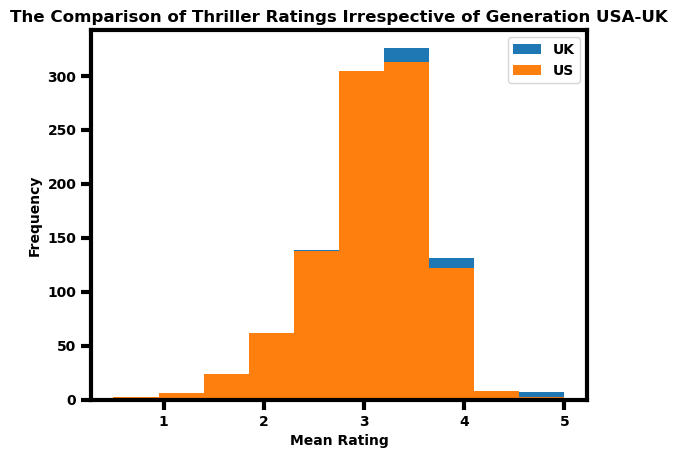

In [772]:
# comparing the mean rating of equivalent thrillers in the UK and US with all observed covariates removed from confounding country allocation
UK = balanced_thriller_us_uk[balanced_thriller_us_uk["countries"] == 0]
UK = UK["mean_rating"]

US = balanced_thriller_us_uk[balanced_thriller_us_uk["countries"] == 1]
US = US["mean_rating"]

print(UK.describe())
print(US.describe())

plt.hist(UK, bins=10, label = "UK")
plt.hist(US, bins=10, label = "US") 

plt.xlabel("Mean Rating", weight='bold')
plt.ylabel("Frequency", weight='bold')
plt.legend() 
plt.title("The Comparison of Thriller Ratings Irrespective of Generation USA-UK", weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)

plt.show()


There is only a slight increase in movie ratings in UK thriller movies, which could be caused by the film being released in the UK given all other observable covariates of the films were matched between the control = UK and treatment = US regions.